## 이 파일은 VSCode Jupyter Notebook으로 열어주시기 바랍니다.

---

# PyKis v2

---

## PyKis 인증 관리

### 시크릿 키 관리 방법

시크릿 키를 관리하는 방법은 크게 2가지가 있습니다.

1. 직접 시크릿 키를 입력하는 방법

In [ ]:
from pykis.kis import PyKis

kis = PyKis(
    appkey="YOUR_APP_KEY",
    appsecret="YOUR_APP_SECRET",
)

2. 시크릿 키를 파일로 관리하는 방법

In [ ]:
# 먼저 시크릿 키를 파일로 저장합니다.
from pykis.client.auth import KisAuth

auth = KisAuth(
    # 앱 키  예) Pa0knAM6JLAjIa93Miajz7ykJIXXXXXXXXXX
    appkey="YOUR_APP_KEY",
    # 앱 시크릿  예) V9J3YGPE5q2ZRG5EgqnLHn7XqbJjzwXcNpvY . . .
    appsecret="YOUR_APP_SECRET",
    # 앱 키와 연결된 계좌번호  예) 00000000-01
    account="00000000-01",
    # 가상계좌 여부
    virtual=False,
)

# 안전한 경로에 시크릿 키를 파일로 저장합니다.
auth.save("secret.json")

In [ ]:
# 저장된 시크릿 키를 사용하여 PyKis 객체를 생성합니다.
from pykis.kis import PyKis
from pykis.client.auth import KisAuth

kis = PyKis("secret.json")
# 또는
kis = PyKis(KisAuth.load("secret.json"))

---

### 엑세스 토큰 관리 방법

한국투자증권 개인 고객의 경우, 엑세스 토큰의 만료 기간은 1일이며, 엑세스 토큰을 발급받으면, 계좌와 연결된 카카오톡으로 알림이 전송됩니다.

PyKis는 하나의 객체마다 엑세스 토큰을 자동으로 관리하기 때문에 일반적인 환경에서는 발급이나 만료를 직접 관리할 필요가 없습니다.

하지만 만약, 계좌와 연결된 PyKis 객체를 유지하기 어려운 환경이라면, 엑세스 토큰을 파일로 저장하여 기간이 남은 토큰을 재사용할 수 있습니다.

In [ ]:
from pykis.kis import PyKis

# PyKis 객체를 생성합니다.
kis = PyKis("secret.json")

# PyKis는 토큰의 수요가 발생할 때 토큰을 발급하므로 아래 변수는 None입니다.
print(kis._token)

# 아래 프로퍼티를 호출하면 만료기간이 보장된 토큰을 발급받을 수 있습니다.
token = kis.token
# 토큰의 정보를 확인합니다.
print(repr(token), str(token))

# 안전한 경로에 해당 토큰을 파일로 저장합니다.
token.save("token.json")

In [ ]:
# 저장된 토큰을 사용하려면 아래와 같이 할 수 있습니다.
from pykis.api.auth.token import KisAccessToken
from pykis.kis import PyKis

kis = PyKis("secret.json", token="token.json")
# 또는
kis = PyKis("secret.json", token=KisAccessToken.load("token.json"))
# 또는
kis = PyKis("secret.json")
kis.token = KisAccessToken.load("token.json")

# 파일로 저장된 토큰이 만료되더라도 PyKis 객체에서 자동으로 갱신합니다.
print(f"남은 유효기간: {kis.token.remaining}")

---

## 종목 시세 및 차트 조회 방법

기본적으로 어떠한 종목이든 시세를 조회하려면 `kis.stock('AAPL')` 처럼 종목의 스코프를 받아와야 합니다.

국내주식, 해외주식에 상관 없이 모두 동일한 방법으로 조회할 수 있습니다.

In [ ]:
# 국내 주식
hynix = kis.stock('000660') # SK하이닉스 (코스피)
ecopro = kis.stock('247540') # 에코프로비엠 (코스닥)

# 해외 주식 (미국)
nvida = kis.stock("NVDA")  # 엔비디아 (나스닥)
coupang = kis.stock("CPNG")  # 쿠팡 (뉴욕)

하지만 종목이 발견될 때 까지 모든 시장을 순회하며 조회하므로 시장 정보를 함께 입력하면 더 빠르게 조회할 수 있습니다.

기본값은 한국 -> 미국 -> 일본 -> 홍콩 -> 베트남 -> 중국 순으로 조회합니다.

In [ ]:
tokyo_electric = kis.stock('9501', market='TKSE') # 도쿄 전력 (도쿄)
# 또는 국가코드를 사용할 수 있습니다.
tokyo_electric = kis.stock('9501', market='JP') # 도쿄 전력 (도쿄)

PyKis의 stock함수로 얻은 종목 스코프(`KisInfoStock`)는 기본적인 종목 정보를 담고 있습니다.

In [ ]:
print(f"""
종목코드: {hynix.symbol}
종목명: {hynix.name}
종목시장: {hynix.market}
""")

# 또한 info 프로퍼티를 통해 상세 정보를 얻을 수 있습니다.
print(f"""
종목코드: {hynix.info.symbol}
종목표준코드: {hynix.info.std_code}
종목명: {hynix.info.name}
종목영문명: {hynix.info.name_eng}
종목시장: {hynix.info.market}
종목시장한글명: {hynix.info.market_name}
""")

이렇게 얻은 종목 스코프를 이용해 시세를 조회할 수 있습니다.

---

### 주식 시세 조회

해당 함수는 국내주식 및 해외주식의 시세를 조회합니다.

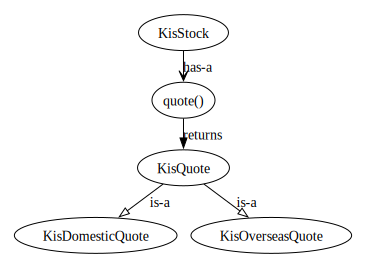

In [29]:
from pykis.api.stock.quote import KisQuote

quote: KisQuote = coupang.quote()

In [ ]:
quote = coupang.quote() # 해당 종목의 시세를 조회합니다.

print(f"""
종목코드: {quote.symbol}
종목명: {quote.name}
종목시장: {quote.market}

업종명: {quote.sector_name}

현재가: {quote.price}
거래량: {quote.volume}
거래대금: {quote.amount}
시가총액: {quote.market_cap}
대비부호: {quote.sign}
위험도: {quote.risk}
거래정지: {quote.halt}
단기과열구분: {quote.overbought}

전일종가: {quote.prev_price}
전일거래량: {quote.prev_volume}
전일대비: {quote.change}

상한가: {quote.high_limit}
하한가: {quote.low_limit}
거래단위: {quote.unit}
호가단위: {quote.tick}
소수점 자리수: {quote.decimal_places}

통화코드: {quote.currency}
당일환율: {quote.exchange_rate}

당일시가: {quote.open}
당일고가: {quote.high}
당일저가: {quote.low}

등락율: {quote.rate}
대비부호명: {quote.sign_name}

==== 종목 지표 ====

EPS (주당순이익): {quote.indicator.eps}
BPS (주당순자산): {quote.indicator.bps}
PER (주가수익비율): {quote.indicator.per}
PBR (주가순자산비율): {quote.indicator.pbr}

52주 최고가: {quote.indicator.week52_high}
52주 최저가: {quote.indicator.week52_low}
52주 최고가 날짜: {quote.indicator.week52_high_date.strftime("%Y-%m-%d")}
52주 최저가 날짜: {quote.indicator.week52_low_date.strftime("%Y-%m-%d")}
""")

---

### 차트 조회

해당 함수는 국내주식 및 해외주식의 당일 분봉과 기간 봉 차트를 조회합니다.

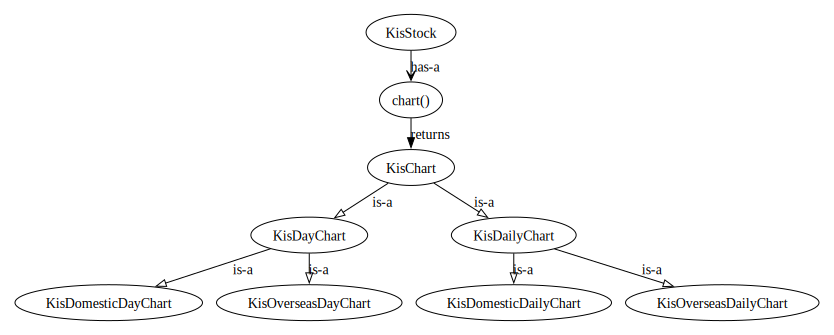

In [30]:
from pykis.api.stock.chart import KisChart
from pykis.api.stock.daily_chart import KisDailyChart
from pykis.api.stock.day_chart import KisDayChart

chart: KisChart = coupang.chart() # 통합 차트 조회
daily_chart: KisDailyChart = coupang.daily_chart() # 일,주,월,년 차트 조회
day_chart: KisDayChart = coupang.day_chart() # 당일 분봉 차트 조회

In [ ]:
from datetime import date, time

chart = coupang.chart() # 기본값은 최근 7일 일봉입니다.
# 최근 기간 조회는 아래와 같이 시간 표현식을 사용할 수 있습니다.
# 1m: 1분
# 1h: 1시간
# 1d: 1일
# 1w: 1주
# 1M: 1개월 (개월 단위는 대문자 M)
# 1y: 1년
# 1y6M: 1년 6개월
chart = coupang.chart("3d") # 최근 3일 일봉입니다.
chart = coupang.chart("1y", period='month') # 최근 1년간의 월봉입니다.
chart = coupang.chart(period='year') # 상장 이래의 연간 일봉입니다.
chart = coupang.chart(start=date(2023, 1, 1)) # 2023년 1월 1일부터 현재까지의 일봉입니다.
chart = coupang.chart(start=date(2023, 1, 1), end=date(2024, 1, 1)) # 2023년 1월 1일부터 2023년 12월 31일까지의 일봉입니다.

chart = coupang.chart('1h', period=1) # 최근 1시간의 1분봉입니다.
chart = coupang.chart(period=5) # 당일 5분봉입니다.
chart = coupang.chart(period=1, end=time(12, 30)) # 당일 12시 30분까지의 1분봉입니다.

시각화 예제입니다.

먼저 필요한 라이브러리를 설치합니다.

In [ ]:
!pip install pandas lightweight-charts

In [6]:
from datetime import datetime, timedelta
from lightweight_charts import JupyterChart

chart_view = JupyterChart(width=1280, height=720)
chart = nvida.chart("1y")

chart_view.set(chart.df())
chart_view.set_visible_range(datetime.now() - timedelta(days=365), datetime.now())

chart_view.load()

[03/24 14:53:54] DEBG API [HHDFS76240000]: {'AUTH': '', 'EXCD': 'NAS', 'SYMB': 'NVDA', 'GUBN': '0', 'BYMD': '', 'MODP': '0'}, . -> 0:MCA00000 (정상처리 되었습니다.)
[03/24 14:53:55] DEBG API [HHDFS76240000]: {'AUTH': '', 'EXCD': 'NAS', 'SYMB': 'NVDA', 'GUBN': '0', 'BYMD': '20231029', 'MODP': '0'}, . -> 0:MCA00000 (정상처리 되었습니다.)
[03/24 14:53:55] DEBG API [HHDFS76240000]: {'AUTH': '', 'EXCD': 'NAS', 'SYMB': 'NVDA', 'GUBN': '0', 'BYMD': '20230606', 'MODP': '0'}, . -> 0:MCA00000 (정상처리 되었습니다.)


---

## ~~예제 작성용 코드~~
해당 예제 파일을 작성할 때 사용한 코드입니다. 무시해도 됩니다.

In [1]:
# kis 로드
from logging import DEBUG
from pykis.kis import PyKis
from pykis import logging

logging.logger.setLevel(DEBUG)

kis = PyKis("B:\\ack.json", token="B:\\ack_tk.json")

kis.token.save("B:\\ack_tk.json")

In [28]:
# UML 시각화
from typing import Callable
from graphviz import Digraph
def class_tree(*classes: type):
    class_dict = {cls: [] for cls in classes}

    for cls in classes:
        parent_classes = [base for base in cls.__bases__ if base != object and base in class_dict]

        for parent in parent_classes:
            class_dict[parent].append(cls)

    def build_tree(cls):
        return (cls, [build_tree(child) for child in class_dict[cls]])

    return [
        build_tree(root)
        for root in (set(classes) - set(child for parent in classes for child in class_dict[parent]))
    ]


def digraph_class_tree(*classes: type):
    dot = Digraph()
    dot.attr('graph', pad='0.3')

    def add_nodes_edges(tree):
        cls, children = tree
        dot.node(str(id(cls)), label=cls.__name__)

        for child in children:
            child_cls, _ = child
            dot.edge(str(id(cls)), str(id(child_cls)), label='is-a', arrowhead='empty')
            add_nodes_edges(child)
    
    for tree in class_tree(*classes):
        add_nodes_edges(tree)

    return dot

def cfrt(cls: type, func: Callable, return_types: list[type]):
    dot = digraph_class_tree(*return_types)
    dot.attr(pad='0.2', ranksep='0.2', nodesep='0.2')


    dot.node(str(id(cls)), label=cls.__name__)
    dot.node(str(id(func)), label=func.__name__)
    
    dot.edge(str(id(cls)), str(id(func)), label='has-a', arrowhead='vee')
    dot.edge(str(id(func)), str(id(return_types[0])), label='returns')

    return dot
